# Import NYC Taxi Public Dataset From BigQuery and Upload

In [68]:
import pandas as pd
import sqlite3

# Assuming the file is named 'TLC_Trip_Data_Jan_2015.parquet' in your workspace
df_agg = pd.read_csv("/kaggle/input/fhv-aggregated/FHV Base Aggregate Report 20240603.csv")

# Explore the data
df_agg.head()

Base License Number                    Base Name  DBA  Year  Month  \
0              B01346              ARECIBO C/S INC  NaN  2016      8   
1              B03017     SDR TRANSPORTATION CORP.  NaN  2018     10   
2              B00014          NY ONE CORP CAR INC  NaN  2016      3   
3              B01065  EL BARRIO'S CAR SERVICE LLC  NaN  2017      1   
4              B02243        BARONAS LUXURY II INC  NaN  2020     12   

  Month Name  Total Dispatched Trips  Total Dispatched Shared Trips  \
0     August                   13290                              0   
1    October                   11456                              0   
2      March                   10713                              0   
3    January                   15095                              0   
4   December                    3783                              0   

   Unique Dispatched Vehicles  
0                          89  
1                          59  
2                         186  
3                          93  
4                          70

# Ride Hailing Market Share

In [2]:
import pandas as pd
import plotly.graph_objects as go

# Load the aggregated data
df_agg = pd.read_csv("/kaggle/input/fhv-aggregated/FHV Base Aggregate Report 20240603.csv")

# Standardize the names of the ride-sharing companies
def standardize_company_name(name):
    if pd.isna(name):
        return "Other"
    name = name.lower()
    if "uber" in name:
        return "Uber"
    elif "lyft" in name:
        return "Lyft"
    elif "juno" in name:
        return "Juno"
    elif "via" in name:
        return "Via"
    else:
        return "Other"

df_agg['Company'] = df_agg['DBA'].apply(standardize_company_name)

# Parse Year and Month to create a datetime column
df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + '-' + df_agg['Month'].astype(str) + '-01')

# Filter for relevant companies only
df_agg_filtered = df_agg[df_agg['Company'].isin(['Uber', 'Lyft', 'Juno', 'Via'])]

# Aggregate trips per day for each company
df_daily_trips = df_agg_filtered.groupby(['Date', 'Company'])['Total Dispatched Trips'].sum().reset_index()

# Calculate total trips per day across all companies
total_trips_per_day = df_daily_trips.groupby('Date')['Total Dispatched Trips'].sum().reset_index()
total_trips_per_day = total_trips_per_day.rename(columns={'Total Dispatched Trips': 'Total Trips'})

# Merge total trips with the daily trips data
df_daily_trips = pd.merge(df_daily_trips, total_trips_per_day, on='Date')

# Calculate market share for each company
df_daily_trips['Market Share'] = df_daily_trips['Total Dispatched Trips'] / df_daily_trips['Total Trips'] * 1

# Pivot the data for stacked area chart
df_pivot = df_daily_trips.pivot(index='Date', columns='Company', values='Market Share').fillna(0)

# Create the figure
fig = go.Figure()

# Define colors for each company
colors = {
    'Uber': 'black',
    'Lyft': 'pink',
    'Juno': None,  # Default color
    'Via': None    # Default color
}

# Add traces for each company in the order they should stack
for company in ['Uber', 'Lyft', 'Juno', 'Via']:
    fig.add_trace(go.Scatter(
        x=df_pivot.index,
        y=df_pivot[company],
        mode='lines',
        name=company,
        stackgroup='one',  # Define stack group
        line=dict(color=colors[company])  # Set the color
    ))

# Update layout to resemble the provided image and show percentages
fig.update_layout(
    title='Ride-hailing Market Share',
    xaxis_title='Date',
    yaxis_title='Market Share (%)',
    yaxis=dict(tickformat='.0%'),
    hovermode='x unified',
    legend_title='Company',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Show the plot
fig.show()
fig.write_html("interactive_graph.html")

# Number of Trips, Shared Trips, Unique Dispatched Vehicles per Day


In [3]:
import pandas as pd
import plotly.graph_objects as go

# Load the aggregated data
df_agg = pd.read_csv("/kaggle/input/fhv-aggregated/FHV Base Aggregate Report 20240603.csv")

# Standardize the names of the ride-sharing companies
def standardize_company_name(name):
    if pd.isna(name):
        return "Other"
    name = name.lower()
    if "uber" in name:
        return "Uber"
    elif "lyft" in name:
        return "Lyft"
    elif "juno" in name:
        return "Juno"
    elif "via" in name:
        return "Via"
    else:
        return "Other"

df_agg['Company'] = df_agg['DBA'].apply(standardize_company_name)

# Parse Year and Month to create a datetime column
df_agg['Date'] = pd.to_datetime(df_agg['Year'].astype(str) + '-' + df_agg['Month'].astype(str) + '-01')

# Filter for relevant companies only
df_agg_filtered = df_agg[df_agg['Company'].isin(['Uber', 'Lyft', 'Juno', 'Via'])]

# Aggregate trips per day for each company
df_daily_trips = df_agg_filtered.groupby(['Date', 'Company'])['Total Dispatched Trips'].sum().reset_index()

# Pivot the data for stacked area chart for total dispatched trips
df_pivot_trips = df_daily_trips.pivot(index='Date', columns='Company', values='Total Dispatched Trips').fillna(0)

# Create the figure for total dispatched trips
fig_trips = go.Figure()

# Define colors for each company
colors = {
    'Uber': 'black',
    'Lyft': 'pink',
    'Juno': None,  # Default color
    'Via': None    # Default color
}

# Add traces for each company in the order they should stack for total dispatched trips
for company in ['Uber', 'Lyft', 'Juno', 'Via']:
    fig_trips.add_trace(go.Scatter(
        x=df_pivot_trips.index,
        y=df_pivot_trips[company],
        mode='lines',
        name=company,
        stackgroup='one',  # Define stack group
        line=dict(color=colors[company])  # Set the color
    ))

# Update layout to resemble the provided image for total dispatched trips
fig_trips.update_layout(
    title='Number of Trips per Day by Ride-hailing Companies',
    xaxis_title='Date',
    yaxis_title='Number of Trips',
    hovermode='x unified',
    legend_title='Company',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Show the plot for total dispatched trips
fig_trips.show()

# Aggregate shared trips per day for each company
df_daily_shared_trips = df_agg_filtered.groupby(['Date', 'Company'])['Total Dispatched Shared Trips'].sum().reset_index()

# Pivot the data for stacked area chart for total dispatched shared trips
df_pivot_shared_trips = df_daily_shared_trips.pivot(index='Date', columns='Company', values='Total Dispatched Shared Trips').fillna(0)

# Create the figure for total dispatched shared trips
fig_shared_trips = go.Figure()

# Add traces for each company in the order they should stack for total dispatched shared trips
for company in ['Uber', 'Lyft', 'Juno', 'Via']:
    fig_shared_trips.add_trace(go.Scatter(
        x=df_pivot_shared_trips.index,
        y=df_pivot_shared_trips[company],
        mode='lines',
        name=company,
        stackgroup='one',  # Define stack group
        line=dict(color=colors[company])  # Set the color
    ))

# Update layout to resemble the provided image for total dispatched shared trips
fig_shared_trips.update_layout(
    title='Number of Shared Trips per Day by Ride-hailing Companies',
    xaxis_title='Date',
    yaxis_title='Number of Shared Trips',
    hovermode='x unified',
    legend_title='Company',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Show the plot for total dispatched shared trips
fig_shared_trips.show()

# Aggregate unique dispatched vehicles per day for each company
df_daily_unique_vehicles = df_agg_filtered.groupby(['Date', 'Company'])['Unique Dispatched Vehicles'].sum().reset_index()

# Pivot the data for stacked area chart for unique dispatched vehicles
df_pivot_unique_vehicles = df_daily_unique_vehicles.pivot(index='Date', columns='Company', values='Unique Dispatched Vehicles').fillna(0)

# Create the figure for unique dispatched vehicles
fig_unique_vehicles = go.Figure()

# Add traces for each company in the order they should stack for unique dispatched vehicles
for company in ['Uber', 'Lyft', 'Juno', 'Via']:
    fig_unique_vehicles.add_trace(go.Scatter(
        x=df_pivot_unique_vehicles.index,
        y=df_pivot_unique_vehicles[company],
        mode='lines',
        name=company,
        stackgroup='one',  # Define stack group
        line=dict(color=colors[company])  # Set the color
    ))

# Update layout to resemble the provided image for unique dispatched vehicles
fig_unique_vehicles.update_layout(
    title='Number of Unique Dispatched Vehicles per Day by Ride-hailing Companies',
    xaxis_title='Date',
    yaxis_title='Number of Unique Dispatched Vehicles',
    hovermode='x unified',
    legend_title='Company',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Show the plot for unique dispatched vehicles
fig_unique_vehicles.show()

In [4]:
import bq_helper
chicago = bq_helper.BigQueryHelper(active_project= "bigquery-public-data", 
                                       dataset_name = "new_york_taxi_trips")
chicago.list_tables()

Using Kaggle's public dataset BigQuery integration.


['taxi_zone_geom',
 'tlc_fhv_trips_2015',
 'tlc_fhv_trips_2016',
 'tlc_fhv_trips_2017',
 'tlc_green_trips_2014',
 'tlc_green_trips_2015',
 'tlc_green_trips_2016',
 'tlc_green_trips_2017',
 'tlc_green_trips_2018',
 'tlc_green_trips_2019',
 'tlc_green_trips_2020',
 'tlc_green_trips_2021',
 'tlc_green_trips_2022',
 'tlc_green_trips_2023',
 'tlc_yellow_trips_2011',
 'tlc_yellow_trips_2012',
 'tlc_yellow_trips_2013',
 'tlc_yellow_trips_2014',
 'tlc_yellow_trips_2015',
 'tlc_yellow_trips_2016',
 'tlc_yellow_trips_2017',
 'tlc_yellow_trips_2018',
 'tlc_yellow_trips_2019',
 'tlc_yellow_trips_2020',
 'tlc_yellow_trips_2021',
 'tlc_yellow_trips_2022',
 'tlc_yellow_trips_2023']

# Number of Trips, Market Share per Month, Farebox per Trip, Total Passenger Fare Paid by Taxi Type

In [2]:
import pandas as pd
import plotly.graph_objects as go
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client()

# Function to load data from specified tables
def load_data(tables, source_name):
    dataframes = []
    for table in tables:
        if 'yellow' in table or 'green' in table:
            query = f"""
            SELECT DATE(pickup_datetime) AS trip_date, 
                   COUNT(*) AS num_trips,
                   AVG(fare_amount) AS farebox_per_trip,
                   SUM(total_amount) AS total_passenger_fare
            FROM `bigquery-public-data.new_york_taxi_trips.{table}`
            GROUP BY trip_date
            ORDER BY trip_date ASC
            """
        elif 'fhv' in table:
            query = f"""
            SELECT DATE(pickup_datetime) AS trip_date, 
                   COUNT(*) AS num_trips,
                   0 AS farebox_per_trip,
                   0 AS total_passenger_fare
            FROM `bigquery-public-data.new_york_taxi_trips.{table}`
            GROUP BY trip_date
            ORDER BY trip_date ASC
            """
        query_job = client.query(query)
        results = query_job.result()
        df = results.to_dataframe()
        df['source'] = source_name
        dataframes.append(df)
    return pd.concat(dataframes)

# Tables to load
green_tables = [f'tlc_green_trips_{year}' for year in range(2014, 2024)]
yellow_tables = [f'tlc_yellow_trips_{year}' for year in range(2011, 2024)]
fhv_tables = [f'tlc_fhv_trips_{year}' for year in range(2015, 2018)]

# Load data
df_green = load_data(green_tables, 'Green Taxis')
df_yellow = load_data(yellow_tables, 'Yellow Taxis')
df_fhv = load_data(fhv_tables, 'For-Hire Vehicles')

# Combine all data into one DataFrame
df_combined = pd.concat([df_green, df_yellow, df_fhv])

# Convert trip_date to datetime
df_combined['trip_date'] = pd.to_datetime(df_combined['trip_date'])

# Filter the date range to 2015-2023
df_combined = df_combined[(df_combined['trip_date'] >= '2015-01-01') & (df_combined['trip_date'] <= '2023-12-31')]

# Resample data by month
df_combined.set_index('trip_date', inplace=True)
df_combined = df_combined.groupby('source').resample('ME').agg({
    'num_trips': 'sum',
    'farebox_per_trip': 'mean',
    'total_passenger_fare': 'sum'
}).reset_index()

# Calculate total trips per month
df_total_trips = df_combined.groupby('trip_date')['num_trips'].sum().reset_index()
df_total_trips = df_total_trips.rename(columns={'num_trips': 'total_trips'})

# Merge total trips with combined data
df_combined = pd.merge(df_combined, df_total_trips, on='trip_date')

# Calculate market share for each source
df_combined['market_share'] = df_combined['num_trips'] / df_combined['total_trips']

# Create the figures
fig_trips = go.Figure()
fig_market_share = go.Figure()
fig_farebox = go.Figure()
fig_total_fare = go.Figure()

# Define colors for each category
colors = {
    'Yellow Taxis': 'yellow',
    'Green Taxis': 'green',
    'For-Hire Vehicles': 'black'
}

# Add traces for each figure
for source in ['Yellow Taxis', 'Green Taxis', 'For-Hire Vehicles']:
    fig_trips.add_trace(go.Scatter(
        x=df_combined[df_combined['source'] == source]['trip_date'],
        y=df_combined[df_combined['source'] == source]['num_trips'],
        mode='lines',
        name=source,
        line=dict(color=colors[source])
    ))

    fig_market_share.add_trace(go.Scatter(
        x=df_combined[df_combined['source'] == source]['trip_date'],
        y=df_combined[df_combined['source'] == source]['market_share'] * 100,
        mode='lines',
        name=source,
        line=dict(color=colors[source])
    ))

    if source != 'For-Hire Vehicles':
        fig_farebox.add_trace(go.Scatter(
            x=df_combined[df_combined['source'] == source]['trip_date'],
            y=df_combined[df_combined['source'] == source]['farebox_per_trip'],
            mode='lines',
            name=source,
            line=dict(color=colors[source])
        ))

        fig_total_fare.add_trace(go.Scatter(
            x=df_combined[df_combined['source'] == source]['trip_date'],
            y=df_combined[df_combined['source'] == source]['total_passenger_fare'],
            mode='lines',
            name=source,
            line=dict(color=colors[source])
        ))

# Update layouts
for fig in [fig_trips, fig_market_share, fig_farebox, fig_total_fare]:
    fig.update_layout(
        xaxis_title='Date',
        hovermode='x unified',
        legend_title='Company',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date",
            range=['2015-01-01', '2023-12-31']
        ),
        template='plotly_white'
    )

fig_trips.update_layout(title='Number of Trips per Month by Taxi Type', yaxis_title='Number of Trips')
fig_market_share.update_layout(title='Market Share per Month by Taxi Type', yaxis_title='Market Share (%)')
fig_farebox.update_layout(title='Farebox per Trip by Taxi Type (Yellow and Green Only)', yaxis_title='Farebox per Trip ($)')
fig_total_fare.update_layout(title='Total Passenger Fare Paid by Taxi Type (Yellow and Green Only)', yaxis_title='Total Passenger Fare Paid ($)')

# Show figures
fig_trips.show()
fig_market_share.show()
fig_farebox.show()
fig_total_fare.show()

Using Kaggle's public dataset BigQuery integration.


# Total Passenger Fare Paid, Total Trips per Month, Year on Year Trips Growth by Taxi Type


In [4]:
import pandas as pd
import plotly.graph_objects as go
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client()

# Function to load data with a given SQL query
def load_data(query):
    query_job = client.query(query)
    results = query_job.result()
    return results.to_dataframe()

# Function to plot the data
def plot_data(df, title, y_label):
    fig = go.Figure()
    colors = {
        'Yellow Taxis': 'yellow',
        'Green Taxis': 'green',
        'For-Hire Vehicles': 'black'
    }
    for company in df.columns:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[company],
            mode='lines',
            name=company,
            line=dict(color=colors[company])
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title=y_label,
        hovermode='x unified',
        legend_title='Company',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date",
            range=['2014-01-01', '2023-12-31']  # Set the date range explicitly
        ),
        template='plotly_white'
    )
    fig.show()

# Dataset ID
dataset_id = "bigquery-public-data.new_york_taxi_trips"

# Query for total passenger fare paid, grouped by month
query_total_fare = f"""
WITH yellow_trips AS (
    SELECT 
        DATE_TRUNC(DATE(pickup_datetime), MONTH) AS trip_month, 
        'Yellow Taxis' AS taxi_type,
        SUM(total_amount) AS total_passenger_fare
    FROM `{dataset_id}.tlc_yellow_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2023'
    GROUP BY trip_month
),
green_trips AS (
    SELECT 
        DATE_TRUNC(DATE(pickup_datetime), MONTH) AS trip_month, 
        'Green Taxis' AS taxi_type,
        SUM(total_amount) AS total_passenger_fare
    FROM `{dataset_id}.tlc_green_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2023'
    GROUP BY trip_month
),
fhv_trips AS (
    SELECT 
        DATE_TRUNC(DATE(pickup_datetime), MONTH) AS trip_month, 
        'For-Hire Vehicles' AS taxi_type,
        COUNT(*) AS total_passenger_fare  -- Using count as a proxy since fare data is not available
    FROM `{dataset_id}.tlc_fhv_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2017'
    GROUP BY trip_month
)
SELECT * FROM yellow_trips
UNION ALL
SELECT * FROM green_trips
UNION ALL
SELECT * FROM fhv_trips
ORDER BY trip_month ASC, taxi_type
"""

df_total_fare = load_data(query_total_fare)
df_total_fare_pivot = df_total_fare.pivot(index='trip_month', columns='taxi_type', values='total_passenger_fare')
plot_data(df_total_fare_pivot, 'Total Passenger Fare Paid per Month by Taxi Type', 'Total Passenger Fare Paid ($)')

# Query for total trips, grouped by month (as a proxy for driver activity)
query_trips = f"""
WITH yellow_trips AS (
    SELECT 
        DATE_TRUNC(DATE(pickup_datetime), MONTH) AS trip_month, 
        'Yellow Taxis' AS taxi_type,
        COUNT(*) AS num_trips
    FROM `{dataset_id}.tlc_yellow_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2014' AND '2023'
    GROUP BY trip_month
),
green_trips AS (
    SELECT 
        DATE_TRUNC(DATE(pickup_datetime), MONTH) AS trip_month, 
        'Green Taxis' AS taxi_type,
        COUNT(*) AS num_trips
    FROM `{dataset_id}.tlc_green_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2014' AND '2023'
    GROUP BY trip_month
),
fhv_trips AS (
    SELECT 
        DATE_TRUNC(DATE(pickup_datetime), MONTH) AS trip_month, 
        'For-Hire Vehicles' AS taxi_type,
        COUNT(*) AS num_trips
    FROM `{dataset_id}.tlc_fhv_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2017'
    GROUP BY trip_month
)
SELECT * FROM yellow_trips
UNION ALL
SELECT * FROM green_trips
UNION ALL
SELECT * FROM fhv_trips
WHERE trip_month BETWEEN '2014-01-01' AND '2023-12-31'
ORDER BY trip_month ASC, taxi_type
"""

df_trips = load_data(query_trips)
df_trips_pivot = df_trips.pivot(index='trip_month', columns='taxi_type', values='num_trips')
plot_data(df_trips_pivot, 'Total Trips per Month by Taxi Type', 'Number of Trips')

# Query for year on year trips growth, grouped by year
query_yoy_growth = f"""
WITH yellow_trips AS (
    SELECT 
        EXTRACT(YEAR FROM pickup_datetime) AS year, 
        'Yellow Taxis' AS taxi_type,
        COUNT(*) AS num_trips
    FROM `{dataset_id}.tlc_yellow_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2023'
    GROUP BY year
),
green_trips AS (
    SELECT 
        EXTRACT(YEAR FROM pickup_datetime) AS year, 
        'Green Taxis' AS taxi_type,
        COUNT(*) AS num_trips
    FROM `{dataset_id}.tlc_green_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2023'
    GROUP BY year
),
fhv_trips AS (
    SELECT 
        EXTRACT(YEAR FROM pickup_datetime) AS year, 
        'For-Hire Vehicles' AS taxi_type,
        COUNT(*) AS num_trips
    FROM `{dataset_id}.tlc_fhv_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2017'
    GROUP BY year
)
SELECT * FROM yellow_trips
UNION ALL
SELECT * FROM green_trips
UNION ALL
SELECT * FROM fhv_trips
ORDER BY year ASC, taxi_type
"""

df_yoy_growth = load_data(query_yoy_growth)
df_yoy_growth_pivot = df_yoy_growth.pivot(index='year', columns='taxi_type', values='num_trips')
plot_data(df_yoy_growth_pivot, 'Year on Year Trips Growth by Taxi Type', 'Number of Trips')

Using Kaggle's public dataset BigQuery integration.


# Top Pickup and Dropoff Locations, Taxi Distribution by Day and Hour, Hotspot Locations

Using Kaggle's public dataset BigQuery integration.


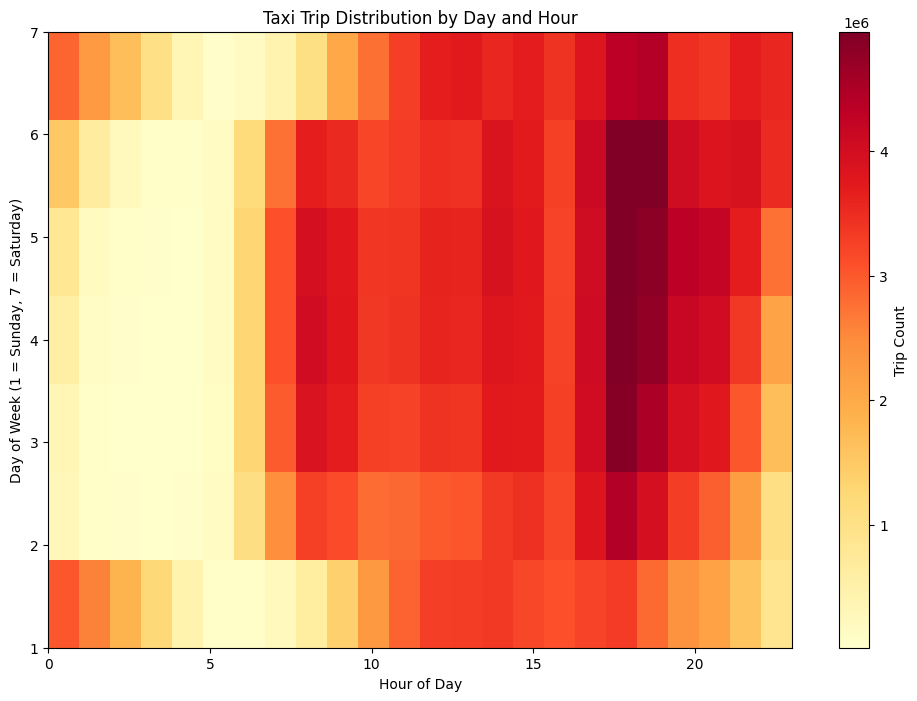

In [67]:
import pandas as pd
from bq_helper import BigQueryHelper
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from IPython.display import display

# Initialize BigQuery helper
bq_helper = BigQueryHelper(active_project="bigquery-public-data", dataset_name="new_york_taxi_trips")

# Query to get top pickup and dropoff locations, and trip counts by hour and day for both green and yellow taxis
query = """
SELECT 
    pickup_location_id, 
    dropoff_location_id,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    EXTRACT(DAYOFWEEK FROM pickup_datetime) AS day_of_week,
    COUNT(*) as trip_count
FROM (
    SELECT pickup_location_id, dropoff_location_id, pickup_datetime
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2023'
    UNION ALL
    SELECT pickup_location_id, dropoff_location_id, pickup_datetime
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2023'
)
GROUP BY 
    1, 2, 3, 4
ORDER BY 
    trip_count DESC
LIMIT 
    100000
"""

df = bq_helper.query_to_pandas(query)

# Get top 10 pickup and dropoff locations
top_pickup = df['pickup_location_id'].value_counts().nlargest(10)
top_dropoff = df['dropoff_location_id'].value_counts().nlargest(10)

# Query to get zone geometries
zone_query = """
SELECT 
    zone_id,
    zone_name,
    ST_CENTROID(zone_geom) AS zone_center
FROM 
    `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`
"""

zone_df = bq_helper.query_to_pandas(zone_query)

# Create a base map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Function to extract lat and lon from zone_center
def extract_lat_lon(zone_center):
    lat_lon = zone_center.strip('POINT()').split()
    return float(lat_lon[1]), float(lat_lon[0])

# Add markers for top pickup locations
for idx, count in top_pickup.items():
    zone = zone_df[zone_df['zone_id'] == idx]
    if not zone.empty:
        lat, lon = extract_lat_lon(zone['zone_center'].iloc[0])
        folium.Marker(
            location=[lat, lon],
            popup=f"Pickup Zone: {zone['zone_name'].iloc[0]}, Count: {count}",
            icon=folium.Icon(color='green', icon='arrow-up')
        ).add_to(nyc_map)

# Add markers for top dropoff locations
for idx, count in top_dropoff.items():
    zone = zone_df[zone_df['zone_id'] == idx]
    if not zone.empty:
        lat, lon = extract_lat_lon(zone['zone_center'].iloc[0])
        folium.Marker(
            location=[lat, lon],
            popup=f"Dropoff Zone: {zone['zone_name'].iloc[0]}, Count: {count}",
            icon=folium.Icon(color='red', icon='arrow-down')
        ).add_to(nyc_map)

# Display the map
display(nyc_map)

# Prepare data for heatmap
df['day_hour'] = df['day_of_week'].astype(str) + '_' + df['hour'].astype(str)
heatmap_data = df.groupby('day_hour')['trip_count'].sum().reset_index()
heatmap_data['day'] = heatmap_data['day_hour'].str.split('_').str[0].astype(int)
heatmap_data['hour'] = heatmap_data['day_hour'].str.split('_').str[1].astype(int)

# Create heatmap
plt.figure(figsize=(12, 8))
heatmap = plt.hist2d(heatmap_data['hour'], heatmap_data['day'], weights=heatmap_data['trip_count'], cmap='YlOrRd', bins=(24, 7))
plt.colorbar(heatmap[3], label='Trip Count')
plt.title('Taxi Trip Distribution by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (1 = Sunday, 7 = Saturday)')
plt.show()

# Create a base map centered on NYC for hotspot map
hotspot_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Prepare data for hotspot map
heat_data = []
for idx, row in df.iterrows():
    zone = zone_df[zone_df['zone_id'] == row['pickup_location_id']]
    if not zone.empty:
        lat, lon = extract_lat_lon(zone['zone_center'].iloc[0])
        heat_data.append([lat, lon, row['trip_count']])

# Add heat map to the base map
HeatMap(heat_data).add_to(hotspot_map)

# Display the hotspot map
display(hotspot_map)